# 04. PyTorch Custom Dataset Video Notebook

We've use some datasets with PyTorch before.

But how do you get your own data into PyTorch?

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* [Book](https://www.learnpytorch.io/04_pytorch_custom_datasets/#04-pytorch-custom-datasets) version of the course materials for 04
* Ground truth version of [notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) 04

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'1.13.0+cu117'

In [2]:
# Setup the device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

Sun Jul  9 22:13:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              16W /  90W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data
See this [notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to know how to create the subset dataset from original dataset.

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 differents classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try thing on small scale and then increasing the scale when necessary.

The whole point is to speed up how fast you can experiment. 

In [4]:
import requests
import zipfile
from pathlib import Path


# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} is already existing, skipping download.')
else:
    print(f"{image_path} doesn't exist, downloading...")
    image_path.mkdir(parents=True,
                     exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak, sushi data...')
    f.write(request.content)

# Unzip pizza, steak and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi is already existing, skipping download.
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os


def walk_through_dir(dir_path):
    """Wakls through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in "data\pizza_steak_sushi".
There are 3 directories and 0 images in "data\pizza_steak_sushi\test".
There are 0 directories and 25 images in "data\pizza_steak_sushi\test\pizza".
There are 0 directories and 19 images in "data\pizza_steak_sushi\test\steak".
There are 0 directories and 31 images in "data\pizza_steak_sushi\test\sushi".
There are 3 directories and 0 images in "data\pizza_steak_sushi\train".
There are 0 directories and 78 images in "data\pizza_steak_sushi\train\pizza".
There are 0 directories and 75 images in "data\pizza_steak_sushi\train\steak".
There are 0 directories and 72 images in "data\pizza_steak_sushi\train\sushi".


In [7]:
# Setup train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with PIL
5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


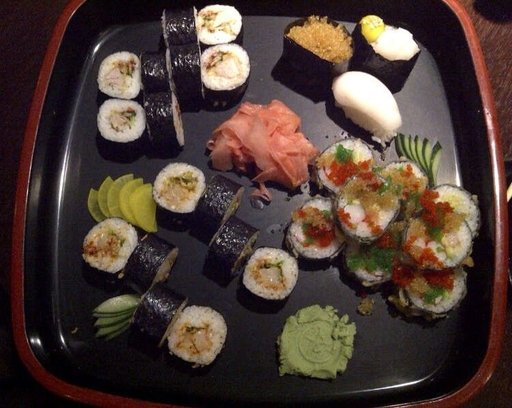

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from the path name (the image class is the name of the directory where the image stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

(-0.5, 511.5, 407.5, -0.5)

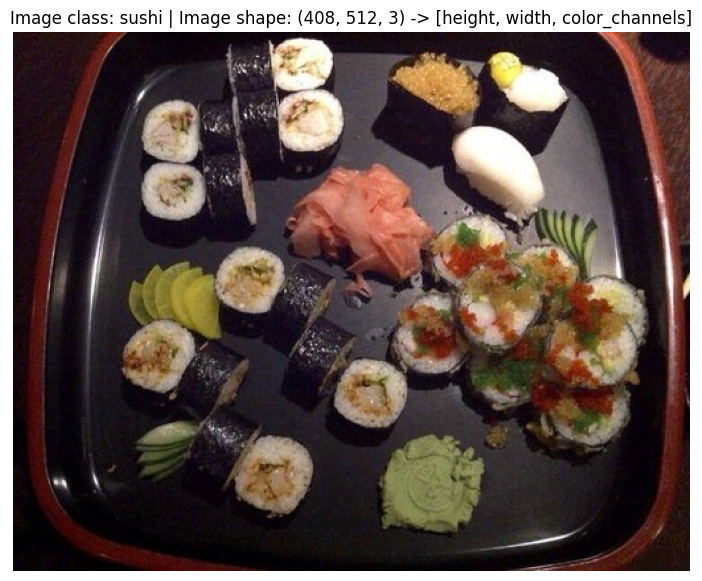

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False)

## 3. Transforming data
Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

[Transforms](https://pytorch.org/vision/stable/transforms.html) help you get your images ready to be used with a model/perform data augmentation.

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64*64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.0824, 0.0824, 0.0863,  ..., 0.1412, 0.1373, 0.1294],
         [0.0902, 0.0902, 0.0902,  ..., 0.1412, 0.1373, 0.1255],
         [0.1137, 0.0980, 0.1059,  ..., 0.1333, 0.1412, 0.1294],
         ...,
         [0.1412, 0.1373, 0.1294,  ..., 0.0157, 0.0196, 0.0157],
         [0.1333, 0.1373, 0.1255,  ..., 0.0275, 0.0275, 0.0275],
         [0.1255, 0.1294, 0.1137,  ..., 0.0275, 0.0314, 0.0314]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0667, 0.0588, 0.0588],
         [0.0353, 0.0431, 0.0392,  ..., 0.0667, 0.0549, 0.0588],
         [0.0392, 0.0471, 0.0471,  ..., 0.0627, 0.0627, 0.0510],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.0078, 0.0078, 0.0039],
         [0.0667, 0.0706, 0.0706,  ..., 0.0118, 0.0118, 0.0118],
         [0.0667, 0.0667, 0.0667,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.0745, 0.0706, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0863, 0.0902, 0.0941,  ..., 0.0863, 0.0784, 0.0784],
         [0.1137, 0.1059, 0.0941,  ..., 0.0941, 0.0863, 0.

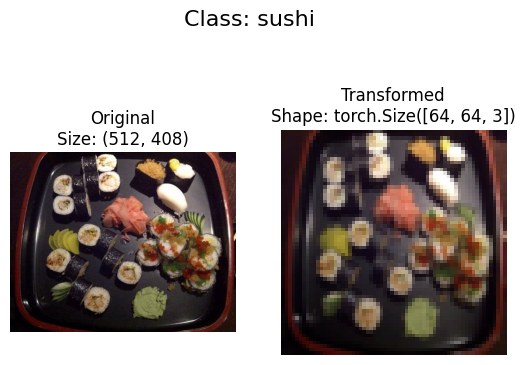

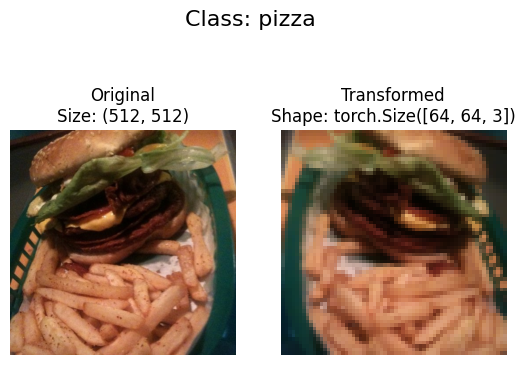

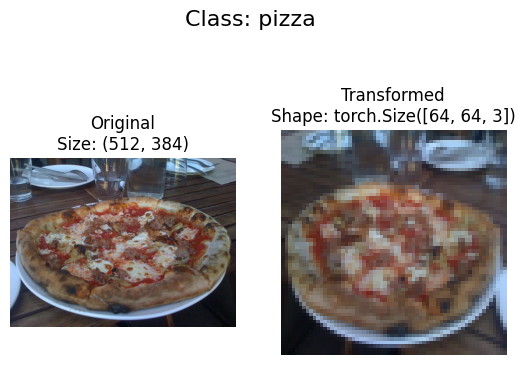

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """Selects random images from a path of images and loads/transforms then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)

    for image_path in random_image_path:

        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot the image
            # Note we will need to change the shape for matplotlib
            transformed_image = transform(f).permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`
We can load image clssification data using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,  # a transform for the data
                                  target_transform=None)  # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image dtype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channel, height, weight]
Image permute: torch.Size([64, 64, 3]) -> [height, weight, color_channel]


Text(0.5, 1.0, 'pizza')

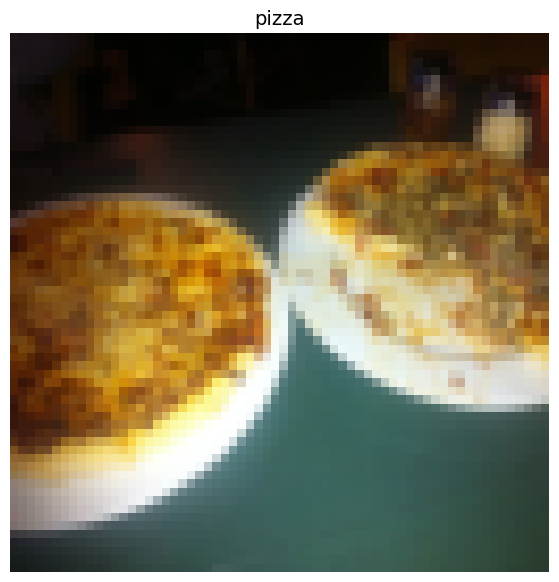

In [20]:
# Rearrage the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color_channel, height, weight]')
print(f'Image permute: {img_permute.shape} -> [height, weight, color_channel]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_name[label], fontsize=14)

## 4.1 Turn loaded image into `DataLoader`'s
A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [21]:
import os
os.cpu_count()

16

In [22]:
# Turn train data and test datasets into DataLoader's
from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x245c953ce80>,
 <torch.utils.data.dataloader.DataLoader at 0x245c94f5b40>)

In [23]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f'Image shape: {img.shape} -> [batch_size, color_channel, height, weight]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, weight]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even through you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issue.

All custom datasets in PyTorch, often subclass:
https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [25]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFoler()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create a helper function to get class names
We want a function to:
1. Get the class name using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class name aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_name_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_name_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the classes folder names in a target directory."""

    # 1. Get the class names by scanning the target directory.
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't found any classes in {directory}, please check file structure.")

    # 3. Create an dictionary of index labels (computers prefer number rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(tuple(classes))}
    return classes, class_to_idx

In [29]:
class_name, class_to_idx = find_classes(target_directory)
class_name, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
   * paths - paths of our images
   * transform - the transform we'd like to use
   * classes - a list of the target classes
   * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [30]:
# Write a custom dataset class
from torch.utils.data import Dataset


# 1. Subclass torch.utils.data.DataSet
class ImageFolderCustom(Dataset):
    # Initialize our custom dataset
    def __init__(self, tar_dir: str,
                 transform: None) -> None:

        # 3. Create several attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(tar_dir).glob('*/*.jpg'))

        # Setup transform
        self.transform = transform

        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(tar_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Open an image via a path and return it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Return the total number of samples."""
        return len(self.paths)

    # 6. Overwrithe __getitem__()
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """Return one sample of data, data and label (X, y)."""
        img = self.load_image(index=index)

        # expects path in format: data_folder/class_name/image.jpg
        class_name = self.paths[index].parent.stem
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        return (self.transform(img), class_idx) if self.transform else (img, class_idx)

        # if self.transform:
        #     # Return data, label (X, y)
        #     return self.transform(img), class_idx
        # else:
        #     return img, class_idx

In [31]:
from torchvision import transforms
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(tar_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(tar_dir=test_dir,

                                     transform=test_transforms)

In [33]:
len(train_data_custom[0])

2

In [34]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x245c9597640>,
 <__main__.ImageFolderCustom at 0x245c95973a0>)

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
len(test_data), len(test_data_custom)

(75, 75)

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
# Check for equality between original ImageFoler Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to display random images 
1. Take in `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup the matplotlib plot.
6. Loot through the random sample images and plot them with matplotlib.
7. Make sure the dimension of our images lines up with matplotlib (HWC).

In [40]:
# 1. Create a function to take in a dataset
def display_random_image(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
    # 2. Adjust to display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larget than 10, setting to 10 and removing shape display.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimension for plotting
        # [color_channel, height, weight] -> [height, weight, color_channel]
        targ_img_adjust = targ_img.permute(1, 2, 0)

        # Plot adjust samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_img_adjust)
        plt.axis('off')
        if classes:
            title = f'Classes: {classes[targ_label]}'
            if display_shape:
                title += f'\nshape: {targ_img_adjust.shape}'
        plt.title(title)

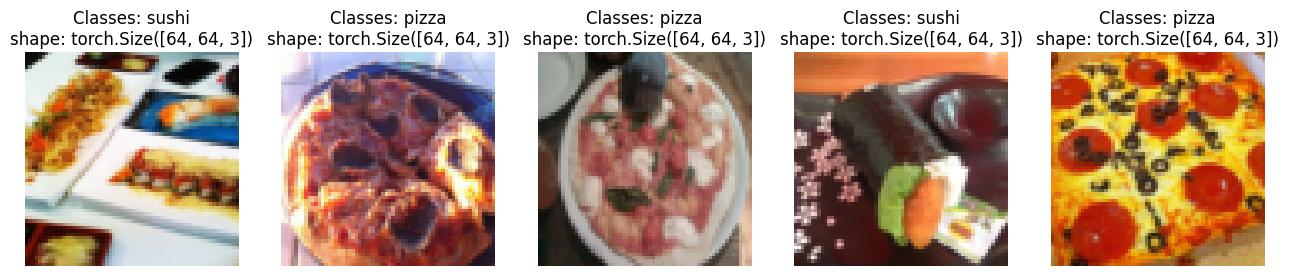

In [41]:
# Display random images from the ImageFolder created Dataset
display_random_image(dataset=train_data,
                     classes=class_name,
                     n=5,
                     seed=42)

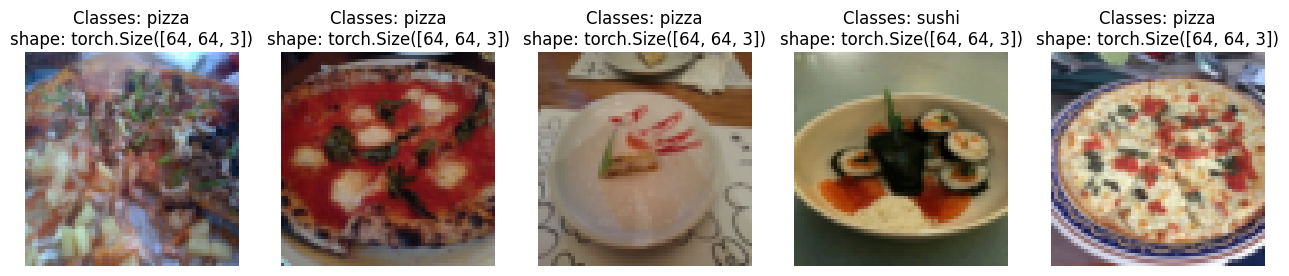

In [42]:
# Display random images from the ImageFolderCustom Dataset
display_random_image(dataset=train_data_custom,
                     classes=class_name,
                     n=5,
                     seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s


In [43]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32
NUM_WORKERs = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x245c97a3400>,
 <torch.utils.data.dataloader.DataLoader at 0x245c9b36ef0>)

In [44]:
# Get image and label from custom dataloader
img_custom, img_label = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, img_label.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transform (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

[Blog post](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [45]:
# Let's look at trivialaugment - https://pytorch.org/vision/main/auto_examples/plot_transforms.html#trivialaugmentwide
from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [46]:
# Get all images path
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

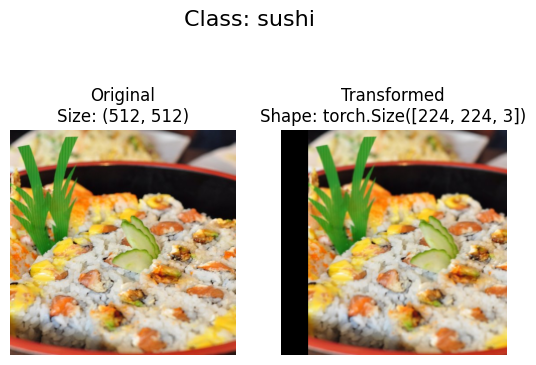

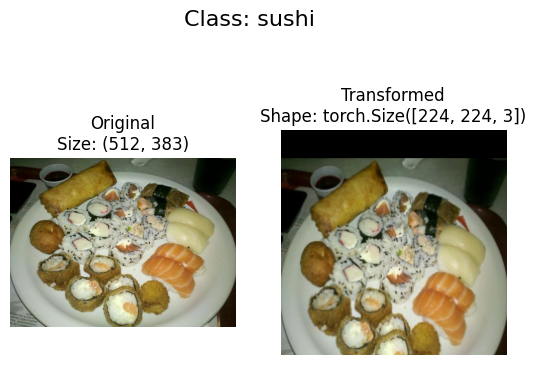

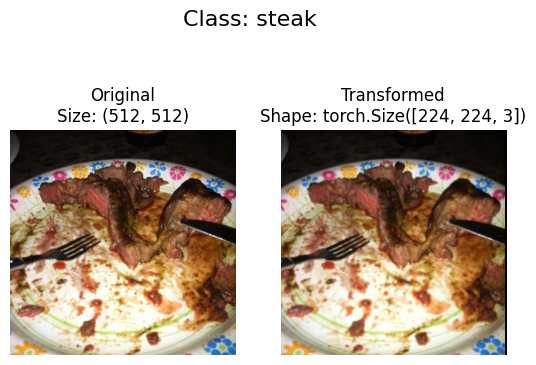

In [47]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the [CNN explainer website](https://poloclub.github.io/cnn-explainer/)

### 7.1 Create a transforms and loading data for Model 0

In [48]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [49]:
# 1. Load and transform data
from torchvision import datasets


train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn dataset into DataLoaders
from torch.utils.data import DataLoader


BATCH_SIZE = 32

# Create DataLoader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

### 7.2 Create TinyVGG model class

In [50]:
class TinyVGG(nn.Module):
    """Model architecture copying from TinyVGG from CNN explainer:
    https://poloclub.github.io/cnn-explainer/"""
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 out_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),           
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  # default stride value is same as kernel size
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=out_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'After conv block 1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'After conv block 2: {x.shape}')
        x = self.classifier(x)
        # print(f'After classifier: {x.shape}')
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))  # benefits from operator fusion:https://horace.io/brrr_intro.html

In [51]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,  # number of color channel in our image data
                  hidden_units=10,
                  out_shape=len(class_name)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [52]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2689e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

## 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [54]:
# Install torchinfo, import if it's available
try:
    import torchinfo
except:
    %pip install torchinfo

from torchinfo import summary


summary(model=model_0,
        input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions
* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.


In [55]:
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224


In [69]:
# Create a train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
 
    # Put the model in train mode
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = map(lambda x: x.to(device), [X, y])

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calcuate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero gradient
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calcuate accuracy metric
        y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
        train_acc +=  ((y_pred_class == y).sum().item()) / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [70]:
# Create a test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn = torch.nn.Module,
              device: torch.device=device):

        # Setup test loss and test accuracy values
        test_loss, test_acc = 0, 0

        with torch.inference_mode():
            # Put the model in test model
            model.eval()

            for batch, (X, y) in enumerate(dataloader):
                X, y = map(lambda x: x.to(device), [X, y])
                
                # 1. Forward pass
                test_pred_logits = model(X)

                # 2. Calculate the loss
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()

                # Calcuate accuracy metric
                test_pred_labels = torch.softmax(test_pred_logits, dim=1).argmax(dim=1)
                test_acc += ((test_pred_labels == y).sum().item()) / len(test_pred_labels)
        
        # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc
            

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [71]:
from tqdm.auto import tqdm

# 1. Creat a train function that takes various model parameters + optimizers + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=torch.nn.CrossEntropyLoss(),
          epochs: int=5,
          device: torch.device=device):
    
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out what's happenin'
        print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate the model 0

In [72]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  out_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=.001)

# Strat the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_result = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0807 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0843 | Train acc: 0.4023 | Test loss: 1.0607 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4102 | Test loss: 1.0650 | Test acc: 0.5644
Total training time: 4.407 seconds


### 7.8 Plot the loss curves of our model 0
A **loss curve** is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen [here](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=zh-tw)

In [74]:
# Get the model_0_results keys
model_0_result.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [75]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plot training curves of a results dictionary."""
    # Get the loss values of the results dictionary(training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary(training and test)
    acc = results['train_acc']
    test_acc = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup the plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, test_loss, label='test loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, test_acc, label='test accuracy')
    plt.title('Accuracy')

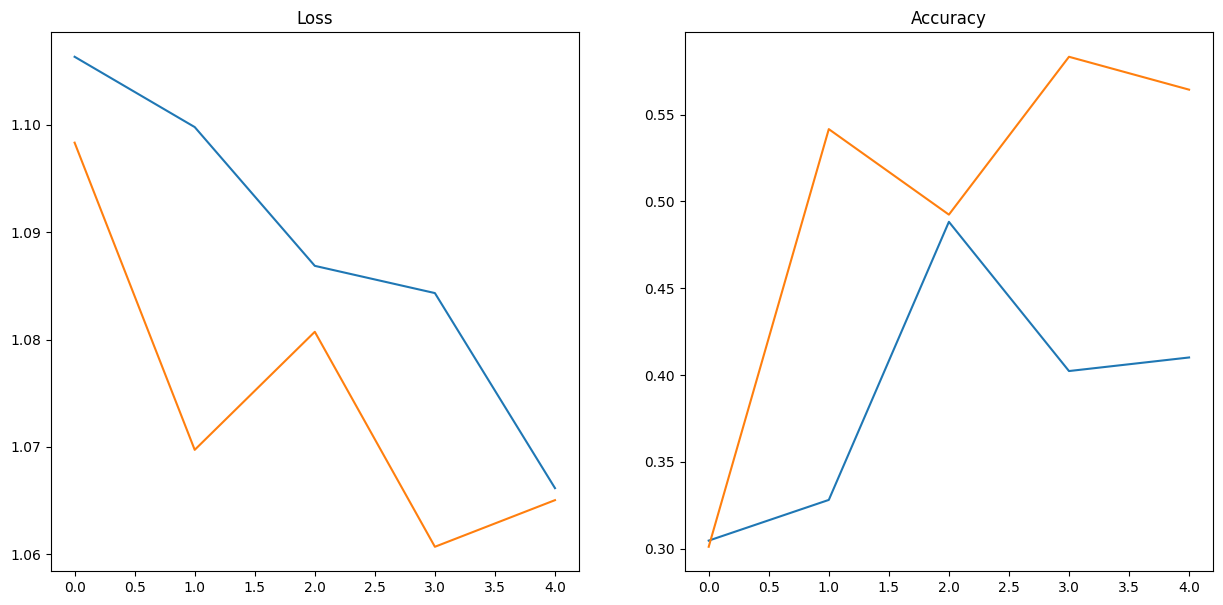

In [76]:
plot_loss_curves(model_0_result)